In [1]:
from chebGreen import ChebGreen
import numpy as np
import matplotlib.pyplot as plt

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
airy = ChebGreen([1,5,10], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
Dataset for for Theta = 1.00. Skipping dataset generation.
Dataset for for Theta = 5.00. Skipping dataset generation.
Dataset for for Theta = 10.00. Skipping dataset generation.
-------------------------------------------------------------------------------

Generating chebfun2 models:
Found saved model, Loading model for example 'airy_equation' at Theta = 1.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 1.00
Chebfun2 model added for example 'airy_equation' at Theta = 1.00

Found saved model, Loading model for example 'airy_equation' at Theta = 5.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 5.00
Chebfun2 model added for example 'airy_equation' at Theta = 5.00

Found saved model, Loading model for example 'airy_equation' at Theta = 10.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 10.00
Chebfun2 model added for example 'airy_equation' at Theta = 10.00



In [3]:
airy.G

{1: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     93       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.238202,
 5: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     93       [0.000 0.000 0.000 0.000]
 vertical scale = 0.138574,
 10: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     93       [0.000 0.000 0.000 -0.000]
 vertical scale = 0.087146}

In [4]:
%%time
u,s,v = airy.G[10].svd()

CPU times: user 3.28 s, sys: 3.16 s, total: 6.44 s
Wall time: 1.67 s


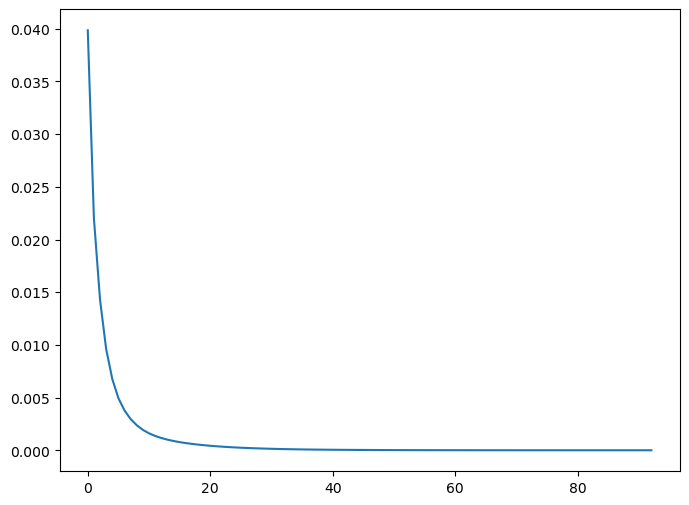

In [5]:
fig = plt.figure(figsize = (8,6))
plt.plot(s)

1.1675855613731667


(0.0, 1.0)

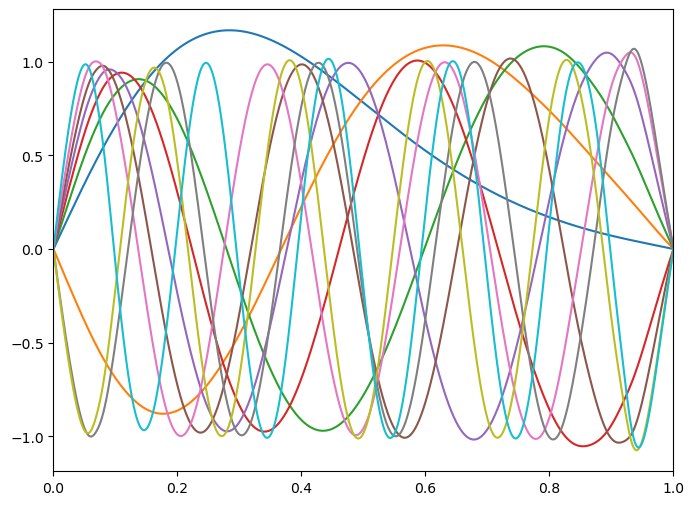

In [6]:
# i = slice(10,20)
i = slice(0,10)
# i = 16
fig = plt.figure(figsize = (8,6))
u[:,i].plot()
print(np.max(u[:,i].vscale))
# plt.title(f'First {i+1} left singular functions for a Laplacian')
plt.xlim([0,1])
# fig.savefig(f'Laplace-first.png', dpi = fig.dpi)

In [7]:
from chebGreen.chebpy2 import Quasimatrix

In [20]:
def compute_order_and_signs(R0: Quasimatrix, R1: Quasimatrix) -> tuple([np.array, np.array]):
    """ Given two orthonormal matrices R0 and R1, this function computes the "correct" ordering and signs of the columns
    (modes) of R1 using R0 as a reference. The assumption is that these are orthonormal matrices, the columns of which
    are eigenmodes of systems which are close to each other and hence the eigenmodes will close to each other as well.
    We thus find an order such that the modes of the second matrix have the maximum inner product (in magnitude) with
    the corresponding mode from the first matrix. If such an ordering doesn't exist the function raises a runtime error.

    Once such an ordering is found, one can flip the signs for the modes of R1, if the inner product is not positive.
    This is necessary when we want to interpolate.

    --------------------------------------------------------------------------------------------------------------------
    Args:
        R0: Orthonormal matrix, the modes of which are used as the reference to re-order and find signs
        R1: Orthonormal matrix for which the modes are supposed to be reordered.

    --------------------------------------------------------------------------------------------------------------------
    Returns:
        New ordering and the signs (sign flips) for matrix R1.
    """
    rank = R0.shape[1]
    order = -1*np.ones(rank).astype(int)
    signs = np.ones(rank)
    
    used = set()
    # For each mode in R1, Search over all modes of R0 for the best matching mode.
    products = np.abs(R0.T * R1) # Compute all the pairwise innerproducts
    for i in range(rank):
        maxidx, maxval = -1, -1
        for j in range(rank):
            current = products[i,j]
            if current >= maxval and (j not in used):
                maxidx = j
                maxval = current
        order[i] = maxidx
        used.add(maxidx)
    
    # Raise an error if the ordering of modes is not a permutation.
    check = set()
    for i in range(rank):
        check.add(order[i])

    if len(check) != rank:
        raise RuntimeError('No valid ordering of modes found')
    
    # Signs are determined according to the correct ordering of modes
    for i in range(rank):
        if (R0[:,i].T * R1[:,int(order[i])]).item() < 0:
            signs[i] = -1
    
    return order, signs

In [41]:
U0,S0,V0 = airy.G[1].svd()
U0 = U0[:,:3]

In [42]:
U,S,V = airy.G[5].svd()
U = U[:,:3]

In [43]:
order,signs = compute_order_and_signs(U0,U)

In [44]:
signs

array([1., 1., 1.])

In [48]:
P = U - (U0 * (U0.T * U + U.T * U0)*0.5)

In [82]:
U2, _ = (U0*0).qr()

In [55]:
U.T * U0

array([[ 0.49487763, -0.07124287,  0.0043345 ],
       [ 0.0713389 ,  0.49265732, -0.04683682],
       [ 0.00232572,  0.04700846,  0.49657802]])

In [56]:
U0.T * U

array([[ 0.49487763,  0.0713389 ,  0.00232572],
       [-0.07124287,  0.49265732,  0.04700846],
       [ 0.0043345 , -0.04683682,  0.49657802]])

In [81]:
(U0.T * U0 + U0.T * U0)*0.5

array([[ 5.00000000e-01, -7.67730559e-17,  1.04767405e-16],
       [-7.67738764e-17,  5.00000000e-01, -3.50703056e-17],
       [ 1.05201086e-16,  2.30429308e-17,  5.00000000e-01]])

In [85]:
P = U0 - (U0 * (U0.T * U0 + U0.T * U0)*0.5)
Ua, _ = (U0).qr()

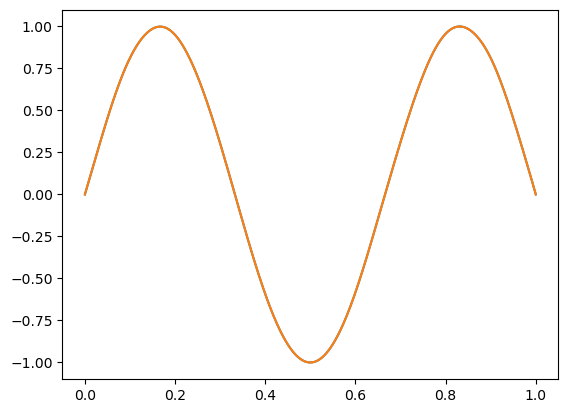

In [89]:
plt.figure()
i = 2
Ua[:,i].plot()
U0[:,i].plot()

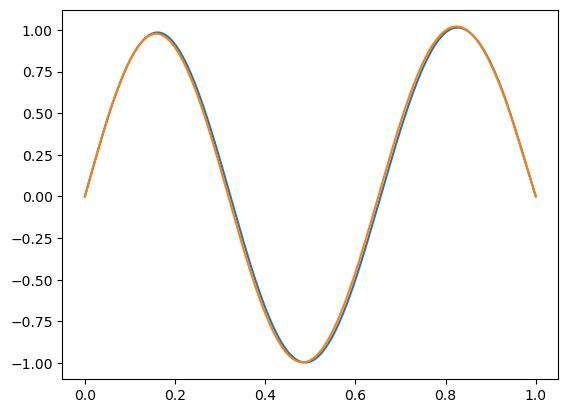

In [52]:
plt.figure()
i = 2
U2[:,i].plot()
U[:,i].plot()

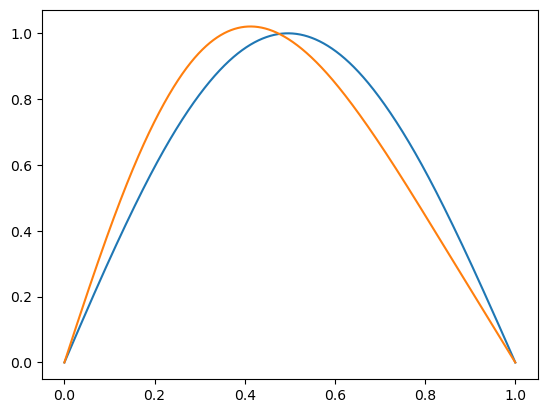

In [53]:
plt.figure()
i = 0
U0[:,i].plot()
U[:,i].plot()